In [3]:
!pip install pytorch-crf

In [4]:
from datasets import load_dataset

dataset = load_dataset("squad_v2")

import random

random.seed(2022119)

shuffled_indices = random.sample(range(len(dataset['train'])), 15000)

train_data = dataset['train'].select(shuffled_indices)

val_data = dataset['validation'].select(range(1000))

from transformers import AutoTokenizer, AutoModelForQuestionAnswering , Trainer
import torch 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("SpanBERT/spanbert-base-cased")

def mark_start_end_bio(of_map, token_type, ans_start, ans_end):
    
    context_first = None ; context_last = None
    
    for j, tt in enumerate(token_type):
        if tt == 1: 
            context_first = j
            break

    if context_first is None : 
        return 0,0

    for j in range(context_first, len(token_type)):
        tt = token_type[j]
        if tt != 1:  
            context_last = j
            break
            
    if context_last is None:
        context_last = len(token_type)

    sidx = -1 ; eidx = -1 
    
    for k in range(context_first, context_last):
        tkn_start, tkn_end = of_map[k]
        if tkn_start <= ans_start < tkn_end:
            sidx = k
            break
            
    if sidx == -1 : 
        return 0,0
        
    for k in range(context_first, context_last):
        tkn_start, tkn_end = of_map[k]
        if tkn_start < ans_end <= tkn_end:
            eidx = k
            break
            
    if eidx == -1 : # in this case ans not completely in span  
        return 0,0
        
    return sidx, eidx


def preprocess_qa_batched_bio(examples):
    tokenized = tokenizer(
        examples["question"],
        examples["context"],
        max_length=384,
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
        truncation="only_second",
    )
    
    start_positions = []
    end_positions = []
    bio_labels = []

    sample_mapping = tokenized.pop("overflow_to_sample_mapping") 
    tokenized['example_id'] = sample_mapping

    for i, offsets in enumerate(tokenized["offset_mapping"]):
        labels = []
        sample_idx = sample_mapping[i]

        if len(examples["answers"][sample_idx]["answer_start"]) == 0:
            start_positions.append(0)
            end_positions.append(0)
            for j in range(len(offsets)) : 
                labels.append(0)
            bio_labels.append(labels)
            continue

        ans_start_char = examples["answers"][sample_idx]["answer_start"][0]
        ans_text = examples["answers"][sample_idx]["text"][0]
        ans_end_char = ans_start_char + len(ans_text)

        q_a_mapping = tokenized.sequence_ids(i)
        
        sidx, eidx = mark_start_end_bio(
            of_map=offsets,
            token_type=q_a_mapping,
            ans_start=ans_start_char,
            ans_end=ans_end_char
        )
        
        for j in range(len(offsets)) : 
            if j < sidx or j > eidx : 
                labels.append(0)
            else : 
                if j == sidx : 
                    labels.append(1)
                else :
                    labels.append(2)
                    
        bio_labels.append(labels)
        start_positions.append(sidx)
        end_positions.append(eidx)

    tokenized["start_positions"] = start_positions
    tokenized["end_positions"] = end_positions
    tokenized['labels'] = bio_labels 

    return tokenized


train = train_data.map(
    preprocess_qa_batched_bio,
    batched=True,
    remove_columns=train_data.column_names,
)


def preprocess_qa_batched_bio_2(examples):
    tokenized = tokenizer(
        examples["question"],
        examples["context"],
        max_length=384,
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
        truncation="only_second",
    )

    start_positions = []
    end_positions = []
    bio_labels = []

    sample_mapping = tokenized.pop("overflow_to_sample_mapping") 
    tokenized['example_id'] = sample_mapping

    for i, offsets in enumerate(tokenized["offset_mapping"]):
        sample_idx = sample_mapping[i]
        temp_starts = [] ; temp_ends = [] ; labels = []
        if len(examples["answers"][sample_idx]["answer_start"]) == 0:
            temp_starts.append(0)
            temp_ends.append(0)
            while(len(temp_starts) < 6):
                temp_starts.append(-1)
                temp_ends.append(-1)
            start_positions.append(temp_starts)
            end_positions.append(temp_ends)
            
            for j in range(len(offsets)): 
                labels.append(0)
            bio_labels.append(labels)
            
            continue

        num_answers = len(examples["answers"][sample_idx]["answer_start"])
        
        bio_flag = 1 
        
        for j in range(num_answers):
            
            ans_start_char = examples["answers"][sample_idx]["answer_start"][j]
            ans_text = examples["answers"][sample_idx]["text"][j]
            ans_end_char = ans_start_char + len(ans_text)
    
            q_a_mapping = tokenized.sequence_ids(i)
    
            sidx, eidx = mark_start_end_bio(
                of_map=offsets,
                token_type=q_a_mapping,
                ans_start=ans_start_char,
                ans_end=ans_end_char
            )

            if bio_flag == 1: 

                for j in range(len(offsets)) : 
                    if j < sidx or j > eidx : 
                        labels.append(0)
                    else : 
                        if j == sidx : 
                            labels.append(1)
                        else :
                            labels.append(2)
                
                bio_flag = 0
            
            temp_starts.append(sidx)
            temp_ends.append(eidx)

        bio_labels.append(labels)
    
        start_positions.append(temp_starts)
        end_positions.append(temp_ends)
        while(len(temp_starts) < 6):
            temp_starts.append(-1)
            temp_ends.append(-1)
            
    tokenized["start_positions"] = start_positions
    tokenized["end_positions"] = end_positions
    tokenized['labels'] = bio_labels 
    
    return tokenized

val = val_data.map(
    preprocess_qa_batched_bio_2,
    batched=True,
    remove_columns=val_data.column_names,
)


import torch
import torch.nn as nn
from transformers import AutoModel
from torchcrf import CRF

class CustomCRF(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = AutoModel.from_pretrained("SpanBERT/spanbert-base-cased")
        self.crf = CRF(3, batch_first=True)
        self.classifier = nn.Linear(self.backbone.config.hidden_size, 3)
        self.relu = nn.ReLU() 

    def forward(self, input_ids, attention_mask, token_type_ids, tags, eval_flag):
        ops = self.backbone(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        logits = self.classifier(ops.last_hidden_state)
        temp = self.relu(logits) # taki model seekh jaye 

        if eval_flag == 1:
            ls = -self.crf(temp, tags, mask=attention_mask.bool())
            pr = self.crf.decode(temp, mask=attention_mask.bool())
            return ls, pr
        else:
            ls = -self.crf(temp, tags, mask=attention_mask.bool())
            return ls

import torch
from torch.utils.data import Dataset , DataLoader
# !pip install pytorch-crf
class CustomDataset(Dataset):
    def __init__(self,data) : 
        self.data = data
    def __len__(self):
        return len(self.data)
    def convert_to_tensor(self,sample) :
        new_sample = {}
        for k,v in sample.items(): 
            new_sample[k] = torch.tensor(v,dtype=torch.long)
        return new_sample
    def __getitem__(self,idx):
        sample = self.data[idx]
        tensor_sample = self.convert_to_tensor(sample)
        return tensor_sample
        
train_ds = CustomDataset(train)

val_ds = CustomDataset(val)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)

val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)

model = CustomCRF()
model.to(device)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/215M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CustomCRF(
  (backbone): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

In [5]:
from transformers import BertForQuestionAnswering, AdamW
from tqdm import tqdm 
import numpy as np
from transformers import get_linear_schedule_with_warmup


def find_ans(lbl_ids, token_type_ids):
    start_flag = False ; start = None ; end = None
    num_labels = len(lbl_ids)
    for i in range(num_labels) :
        lbl = lbl_ids[i]
        tt = token_type_ids[i]      
        if tt == 1:
            if lbl == 1:
                start = i
                start_flag = True
                end = start + 1
                while end < len(lbl_ids) and lbl_ids[end] == 2 : 
                    end += 1
                end -=1 
                return start , end
                
    return 0,0


def exact_match_score(predictions, references):
    assert len(predictions) == len(references), "Lists must have the same length"
    matches = sum(p == r for p, r in zip(predictions, references))
    return matches / len(references) * 100  


optim = AdamW(model.parameters(),lr=3e-5,weight_decay=0.01)

tsteps = (len(train_loader) * 6)
wsteps = int(0.1*tsteps)

LRscheduler = get_linear_schedule_with_warmup(
    optim,
    num_warmup_steps=wsteps,
    num_training_steps=tsteps
)
# [1,1,1,1,0]
# [2,1,0,2]

tl_arr = []

vl_arr = []

for epoch in range(6) : 
    
    model.train()
    
    tl = 0 
    
    m = len(train_loader)
    
    for idx , sample in enumerate(tqdm(train_loader)):
        
        ids = sample['input_ids'].to(device).squeeze(1)
        attn_mask = sample['attention_mask'].to(device).squeeze(1) 
        ttis = sample['token_type_ids'].to(device).squeeze(1) 
        st_posn = sample['start_positions'].to(device) 
        end_posn = sample['end_positions'].to(device)
        lbls = sample['labels'].to(device)
        optim.zero_grad()

        ops = model(input_ids=ids,
                attention_mask=attn_mask,
                token_type_ids=ttis,
                tags = lbls, 
                eval_flag = 0
            )

        loss = ops

        loss.backward()

        optim.step()

        LRscheduler.step()

        tl += loss.item() 

    tl = tl / (m)

    print(f"Epoch {epoch} : loss : {tl}")

    batch_predictions = [] ; batch_references = [] ; example_to_feature = {}

    model.eval()
    
    vl = 0

    gt = 0 

    exid_2_fidx = {}
    
    with torch.no_grad():
    
        for sample in tqdm(val_loader) : 
            
            ids = sample['input_ids'].to(device).squeeze(1)
            attn_mask = sample['attention_mask'].to(device).squeeze(1) 
            ttis = sample['token_type_ids'].to(device).squeeze(1) 
            st_posn = sample['start_positions'].to(device) 
            end_posn = sample['end_positions'].to(device)
            st1 = torch.tensor([i[0] for i in sample['start_positions']]).to(device)
            ed1 = torch.tensor([i[0] for i in sample['end_positions']]).to(device)
            ex_ids = sample['example_id'].to(device)
            lbls = sample['labels'].to(device)
            
            loss , ops2 = model(
                input_ids=ids,
                attention_mask=attn_mask,
                token_type_ids=ttis,
                tags = lbls,
                eval_flag = 1
            )
            
            # print(len(ops2) , len(ops2[0]))
            # print(ops2)
            
            num_samples = (len(ops2))
    
            vl += loss.item()
            
            for i in range(num_samples):

                ex_id = (sample['example_id'][i]).item()

                if ex_id not in exid_2_fidx : 
                    
                    exid_2_fidx[ex_id] = []
                    
                exid_2_fidx[ex_id].append(gt)

                gt += 1

                lbl_pred = ops2[i]

                token_types = ttis[i].cpu().numpy()
                
                start_idx, end_idx = find_ans(lbl_pred, token_types)

    
                if (start_idx == 0 and end_idx == 0) or start_idx > end_idx:
                    
                    pred_answer = "" ; 
                    
                else:
    
                     idx = ex_ids[i]

                     s2 = sample["offset_mapping"][i][start_idx][0]
                     e2 = sample["offset_mapping"][i][end_idx][1]                    
                     pred_answer = val_data['context'][ex_id][s2 : e2]

                maxi = -1

                best_ref = ""

                for j in range(len(st_posn[i])):

                    if st_posn[i][j] == -1:
                        
                        break

                    if st_posn[i][j] == 0 and end_posn[i][j] == 0 : 
    
                        ref_answer = ""
                        
                    else:
                        
                         s3 = sample["offset_mapping"][i][st_posn[i][j]][0]
                         e3 = sample["offset_mapping"][i][end_posn[i][j]][1]
                         ref_answer = val_data['context'][ex_id][s3 : e3]
                     
                    if exact_match_score([pred_answer], [ref_answer]) > maxi:
                        maxi = exact_match_score([pred_answer], [ref_answer])
                        best_ref = ref_answer
                    
                batch_predictions.append(pred_answer) ; batch_references.append(best_ref)

        
        final_preds = [] ; final_refs = []
        
        # print(len(exid_2_fidx))
        # print()
        for exid in list(exid_2_fidx.keys()) : 
            fids = exid_2_fidx[exid] ; max_em = -1
            best_pred = "-1" ; best_ref = "-1"
            for fidx in fids : 
                pred = batch_predictions[fidx] ; ref = batch_references[fidx] 
                temp_em = exact_match_score([pred] , [ref])
                if temp_em > max_em : 
                    best_pred = pred ; best_ref = ref ; max_em = temp_em 
            final_preds.append(best_pred) ; final_refs.append(best_ref)

        em = exact_match_score(final_preds , final_refs)

    tl_arr.append(tl)
    vl_arr.append(vl / m)
    print("="*75)
    print(f"Epoch {epoch} : loss : {vl / m} em : {em}")
    print("-"*75)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 957/957 [25:23<00:00,  1.59s/it]


Epoch 0 : loss : 632.828038549473


100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


Epoch 0 : loss : 13.226995502021495 em : 50.4
---------------------------------------------------------------------------


100%|██████████| 957/957 [25:32<00:00,  1.60s/it]


Epoch 1 : loss : 305.64386164905386


100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


Epoch 1 : loss : 11.418956218468358 em : 50.4
---------------------------------------------------------------------------


100%|██████████| 957/957 [25:33<00:00,  1.60s/it]


Epoch 2 : loss : 297.5461687907156


100%|██████████| 63/63 [00:41<00:00,  1.51it/s]


Epoch 2 : loss : 11.438652524878364 em : 50.4
---------------------------------------------------------------------------


100%|██████████| 957/957 [25:36<00:00,  1.61s/it]


Epoch 3 : loss : 233.70365360463302


100%|██████████| 63/63 [00:42<00:00,  1.50it/s]


Epoch 3 : loss : 7.207366225861457 em : 46.9
---------------------------------------------------------------------------


100%|██████████| 957/957 [25:35<00:00,  1.60s/it]


Epoch 4 : loss : 147.65227577903053


100%|██████████| 63/63 [00:42<00:00,  1.49it/s]


Epoch 4 : loss : 6.458296852550287 em : 43.1
---------------------------------------------------------------------------


100%|██████████| 957/957 [25:35<00:00,  1.60s/it]


Epoch 5 : loss : 121.92395509024274


100%|██████████| 63/63 [00:42<00:00,  1.49it/s]

Epoch 5 : loss : 6.157536075157556 em : 42.9
---------------------------------------------------------------------------


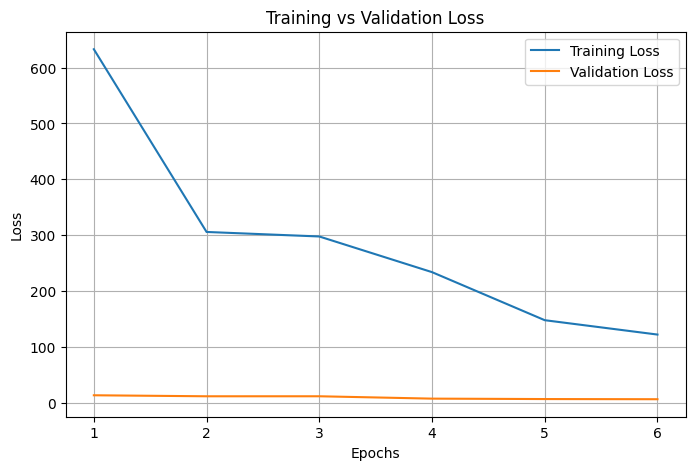

In [12]:
import matplotlib.pyplot as plt

epochs = range(1, len(tl_arr) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, tl_arr, label="Training Loss")
plt.plot(epochs, vl_arr, label="Validation Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

plt.show()


In [ ]:

val_data = dataset['validation'].select(range(11872))
val = val_data.map(
    preprocess_qa_batched_bio_2,
    batched=True,
    remove_columns=val_data.column_names,
)
val_ds = CustomDataset(val)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)
batch_predictions = [] ; batch_references = [] ; example_to_feature = {}

model.eval()

vl = 0

gt = 0 

exid_2_fidx = {}

with torch.no_grad():

    for sample in tqdm(val_loader) : 
        
        ids = sample['input_ids'].to(device).squeeze(1)
        attn_mask = sample['attention_mask'].to(device).squeeze(1) 
        ttis = sample['token_type_ids'].to(device).squeeze(1) 
        st_posn = sample['start_positions'].to(device) 
        end_posn = sample['end_positions'].to(device)
        st1 = torch.tensor([i[0] for i in sample['start_positions']]).to(device)
        ed1 = torch.tensor([i[0] for i in sample['end_positions']]).to(device)
        ex_ids = sample['example_id'].to(device)
        lbls = sample['labels'].to(device)
        
        loss , ops2 = model(
            input_ids=ids,
            attention_mask=attn_mask,
            token_type_ids=ttis,
            tags = lbls,
            eval_flag = 1
        )
        
        # print(len(ops2) , len(ops2[0]))
        # print(ops2)
        
        num_samples = (len(ops2))
    
        vl += loss.item()
        
        for i in range(num_samples):
    
            ex_id = (sample['example_id'][i]).item()
    
            if ex_id not in exid_2_fidx : 
                
                exid_2_fidx[ex_id] = []
                
            exid_2_fidx[ex_id].append(gt)
    
            gt += 1
    
            lbl_pred = ops2[i]
    
            token_types = ttis[i].cpu().numpy()
            
            start_idx, end_idx = find_ans(lbl_pred, token_types)
    
    
            if (start_idx == 0 and end_idx == 0) or start_idx > end_idx:
                
                pred_answer = "" ; 
                
            else:
    
                 idx = ex_ids[i]
    
                 s2 = sample["offset_mapping"][i][start_idx][0]
                 e2 = sample["offset_mapping"][i][end_idx][1]                    
                 pred_answer = val_data['context'][ex_id][s2 : e2]
    
            maxi = -1
    
            best_ref = ""
    
            for j in range(len(st_posn[i])):
    
                if st_posn[i][j] == -1:
                    
                    break
    
                if st_posn[i][j] == 0 and end_posn[i][j] == 0 : 
    
                    ref_answer = ""
                    
                else:
                    
                     s3 = sample["offset_mapping"][i][st_posn[i][j]][0]
                     e3 = sample["offset_mapping"][i][end_posn[i][j]][1]
                     ref_answer = val_data['context'][ex_id][s3 : e3]
                 
                if exact_match_score([pred_answer], [ref_answer]) > maxi:
                    maxi = exact_match_score([pred_answer], [ref_answer])
                    best_ref = ref_answer
                
            batch_predictions.append(pred_answer) ; batch_references.append(best_ref)
    
    
    final_preds = [] ; final_refs = []
    
    # print(len(exid_2_fidx))
    # print()
    for exid in list(exid_2_fidx.keys()) : 
        fids = exid_2_fidx[exid] ; max_em = -1
        best_pred = "-1" ; best_ref = "-1"
        for fidx in fids : 
            pred = batch_predictions[fidx] ; ref = batch_references[fidx] 
            temp_em = exact_match_score([pred] , [ref])
            if temp_em > max_em : 
                best_pred = pred ; best_ref = ref ; max_em = temp_em 
        final_preds.append(best_pred) ; final_refs.append(best_ref)
    
    em = exact_match_score(final_preds , final_refs)
    print("em on whole val ",em)

 17%|█▋        | 133/769 [02:28<12:16,  1.16s/it]